## Loading the dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("nsarker/flower-detection")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4317
    })
})


In [57]:
import os
import tensorflow as tf
from pathlib import Path

# Directory structure setup
new_base_dir = Path("flower_photos_subset")

def make_subset(dataset, subset_name, start_index, end_index):
    """
    Creates a subset of the dataset and saves it to disk in the specified directory structure.
    """
    subset = dataset.select(range(start_index, end_index))  # Select a subset of the dataset
    for i, data in enumerate(subset):
        image = data['image']  # Access the image
        label = data['label']  # Access the label (should be an integer or string)

        # Define category folder (assumes labels are integers or can be converted to strings)
        category = str(label)
        dir_path = new_base_dir / subset_name / category
        os.makedirs(dir_path, exist_ok=True)

        # Save the image
        image_path = dir_path / f"image_{i + start_index}.jpg"
        tf.keras.utils.save_img(image_path, image)


In [58]:
# Split the dataset into train, validation, and test subsets
train_size = int(0.8 * len(dataset['train']))
val_size = int(0.1 * len(dataset['train']))
test_size = len(dataset['train']) - train_size - val_size

# Create subsets
make_subset(dataset['train'], "train", start_index=0, end_index=train_size)
make_subset(dataset['train'], "validation", start_index=train_size, end_index=train_size + val_size)
make_subset(dataset['train'], "test", start_index=train_size + val_size, end_index=train_size + val_size + test_size)


In [76]:
from tensorflow.keras.utils import image_dataset_from_directory

# Base directory
data_dir = new_base_dir

# Load the datasets
train_dataset = image_dataset_from_directory(
    data_dir / "train",
    image_size=(224, 224),  # Resize to 224x224
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    data_dir / "validation",
    image_size=(224, 224),  # Resize to 224x224
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    data_dir / "test",
    image_size=(224, 224),  # Resize to 224x224
    batch_size=32
)


class_names = train_dataset.class_names
print(class_names)


Found 904 files belonging to 5 classes.
Found 113 files belonging to 5 classes.
Found 113 files belonging to 5 classes.
['0', '1', '2', '3', '4']


In [77]:
class_names = [0, 1,2,3,4] 

In [78]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [79]:
# Print the keys in the dataset
print(dataset["train"].features)


{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], id=None)}


In [109]:
# Define class names from the dataset features
class_names = dataset["train"].features["label"].names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [110]:
import matplotlib.pyplot as plt

# Visualize a few images and their labels
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


AttributeError: '_MapDataset' object has no attribute 'class_names'

In [102]:
def convert_to_binary(images, labels):
    binary_labels = tf.where(labels == 0, 1, 0)  # Class 0 becomes 1, others become 0
    return images, binary_labels

# Apply the transformation
train_dataset = train_dataset.map(convert_to_binary)
validation_dataset = validation_dataset.map(convert_to_binary)
test_dataset = test_dataset.map(convert_to_binary)


In [103]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [104]:
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Verify the model
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

In [95]:
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(224, 224, 3))  # Ensure input shape matches your dataset
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation="relu")(x)
x = layers.Flatten()(x)
# Output layer for multiclass classification
outputs = layers.Dense(3, activation="softmax")(x)  # Update output layer to 3 classes
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Verify the model
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                      

In [105]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)


Epoch 1/10
29/29 [==============================] - 16s 520ms/step - loss: 0.6892 - accuracy: 0.5542 - val_loss: 0.6817 - val_accuracy: 0.5752
Epoch 2/10
29/29 [==============================] - 15s 500ms/step - loss: 0.6884 - accuracy: 0.5708 - val_loss: 0.6863 - val_accuracy: 0.5752
Epoch 3/10
29/29 [==============================] - 15s 501ms/step - loss: 0.6822 - accuracy: 0.5708 - val_loss: 0.6843 - val_accuracy: 0.5752
Epoch 4/10
29/29 [==============================] - 15s 500ms/step - loss: 0.6883 - accuracy: 0.5708 - val_loss: 0.6830 - val_accuracy: 0.5752
Epoch 5/10
29/29 [==============================] - 59s 2s/step - loss: 0.6838 - accuracy: 0.5708 - val_loss: 0.6818 - val_accuracy: 0.5752
Epoch 6/10
29/29 [==============================] - 73s 2s/step - loss: 0.6836 - accuracy: 0.5708 - val_loss: 0.6819 - val_accuracy: 0.5752
Epoch 7/10
29/29 [==============================] - 40s 1s/step - loss: 0.6839 - accuracy: 0.5708 - val_loss: 0.6818 - val_accuracy: 0.5752
Epoch 8/

In [106]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")


4/4 [==============================] - 0s 93ms/step - loss: 0.6687 - accuracy: 0.6195
Test Accuracy: 0.62


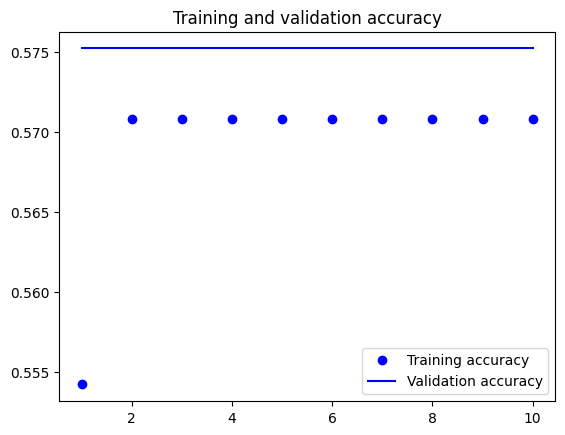

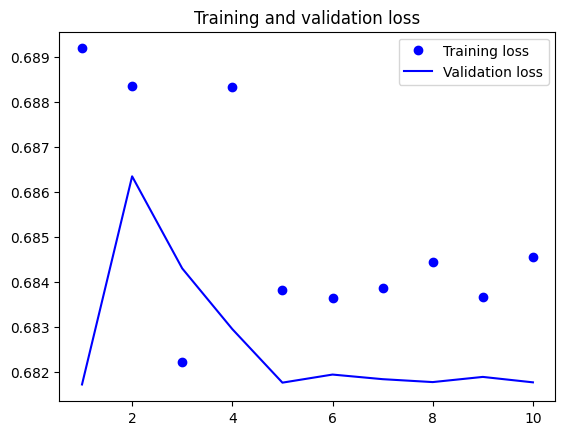

In [107]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()